In [18]:
import shap
import shap.maskers
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

import NN_Architectures as arch
from Functions.DataSet import PhenologicalDatasetTransposedMA
from sklearn.cluster import KMeans


In [19]:

def get_feature_label(X):
    dict_names ={
        0: 'Rank One Leaf Date',
        1: 'Appeared Spathe Date',
        2: 'Opened Spathe Date',
        3: 'Flowering Date',
        4: 'Harvest Date',
        5: 'Bunch Mass',
        6: 'Aborted Inflorescence',
        7: 'Bunch Load',
        8: 'Female Inflorescence',
        9: 'Male Inflorescence',
        
        10: 'Tempertaure (Min)',
        11: 'Tempearture (Max)',
        12: 'Tempearture (Average)',
        13: 'RH (Min)',
        14: 'RH (Max)',
        15: 'RH (Average)',
        16: 'Wind Speed',
        17: 'Rainfall',
        18: 'Rg'
    }
    dict_names_ex ={
        0: 'RankOneLeafDate',
        1: 'AppearedSpatheDate_compl',
        2: 'OpenedSpatheDate_compl',
        3: 'FloweringDate_compl',
        4: 'HarvestDate_compl',
        5: 'BunchMass',
        6: 'AbortedInflo',
        7: 'TMin',
        8: 'TMax',
        9: 'TAverage',
        10: 'HRMin',
        11: 'HRMax',
        12: 'HRAverage',
        13: 'WindSpeed',
        14: 'Rainfall',
        15: 'Rg'
    }
    dict_names_ex_flowers ={
    0: 'RankOneLeafDate',
    1: 'AppearedSpatheDate_compl',
    2: 'OpenedSpatheDate_compl',
    3: 'FloweringDate_compl',
    4: 'HarvestDate_compl',
    5: 'BunchMass',
    6: 'AbortedInflo',
    7: 'BunchLoad',

    8: 'TMin',
    9: 'TMax',
    10: 'TAverage',
    11: 'HRMin',
    12: 'HRMax',
    13: 'HRAverage',
    14: 'WindSpeed',
    15: 'Rainfall',
    16: 'Rg'
    }

    try:
        if len(X[0]) == 19:
            dict_names = dict_names
        elif len(X[0]) == 16:
            dict_names = dict_names_ex
        elif len(X[0]) == 17:
            dict_names = dict_names_ex_flowers
    except:
        if len(X) == 19:
            dict_names = dict_names
        elif len(X) == 16:
            dict_names = dict_names_ex
        elif len(X) == 17:
            dict_names = dict_names_ex_flowers

    return dict_names

    



'''
    output: tuple of two tuples
    output[0]:tuple of five numpy arrays, feature wise shapley values
        output[0][0]: all_features_shaps: list of numpy arrays of shap values for each feature (time series for each feature)
    
        output[0][1]: abs_sum_feature_shaps: sum of absolute shap values for each feature (total strength of the feature, data point for each feature) 
        output[0][2]: sum_feature_shaps: sum of shap values for each feature (total contribution of the feature, plus or minus tendency)

        output[0][3]: abs_avg_feature_shaps: average of absolute shap values for each feature (average strength of a feature per data point, data point for each feature)
        output[0][4]:avg_feature_shaps: average of shap values for each feature (average contribution of a feature per data point)
        
    output[1]: tuple of 4 numpy arrays, time wise shapley values    
        output[1][0]: avg_abs_time_shaps: numpy array of average of absolute shap values for each 20_day_period (data point for each 20_day_period)
        output[1][1]: avg_time_shaps: numpy array of average of shap values for each 20_day_period (data point for each 20_day_period)
        output[1][2]: sum_abs_time_shaps: numpy array of sum of absolute shap values for each 20_day_period (data point for each 20_day_period) 
        output[1][3]: sum_time_shaps: numpy array of sum of shap values for each 20_day_period (data point for each 20_day_period)
    output[2]: shapley_values: numpy array of shapley values
    output[3]: n_pheno_features: number of phenological features in the dataset
    output[4]: samples: number of samples in the dataset

'''

'\n    output: tuple of two tuples\n    output[0]:tuple of five numpy arrays, feature wise shapley values\n        output[0][0]: all_features_shaps: list of numpy arrays of shap values for each feature (time series for each feature)\n    \n        output[0][1]: abs_sum_feature_shaps: sum of absolute shap values for each feature (total strength of the feature, data point for each feature) \n        output[0][2]: sum_feature_shaps: sum of shap values for each feature (total contribution of the feature, plus or minus tendency)\n\n        output[0][3]: abs_avg_feature_shaps: average of absolute shap values for each feature (average strength of a feature per data point, data point for each feature)\n        output[0][4]:avg_feature_shaps: average of shap values for each feature (average contribution of a feature per data point)\n        \n    output[1]: tuple of 4 numpy arrays, time wise shapley values    \n        output[1][0]: avg_abs_time_shaps: numpy array of average of absolute shap va

In [20]:
# Load the pickle file


def open_data(file_path):
    with open(file_path, 'rb') as file:
        shap_data = pickle.load(file)
        title = ''
        for x in (file_path.split('/')[-1]).split('_')[3:6]:
            title += x + ' '
    return shap_data, title

paths = [
    '/home/u108-n256/PalmProject/NeuralNetwork_Testing/Saved_Objects/Shapley-Values/processed_shapley_values/202407_SHAP_values_Female_TransformerCNN_alldata_processed.pkl',
    '/home/u108-n256/PalmProject/NeuralNetwork_Testing/Saved_Objects/Shapley-Values/processed_shapley_values/202407_SHAP_values_Female_TransformerCNN_nf_processed.pkl',
    '/home/u108-n256/PalmProject/NeuralNetwork_Testing/Saved_Objects/Shapley-Values/processed_shapley_values/202407_SHAP_values_Female_TransformerCNN_nfb_processed.pkl',
    '/home/u108-n256/PalmProject/NeuralNetwork_Testing/Saved_Objects/Shapley-Values/processed_shapley_values/202407_SHAP_values_Female_CNN_nfb_processed.pkl',
    '/home/u108-n256/PalmProject/NeuralNetwork_Testing/Saved_Objects/Shapley-Values/processed_shapley_values/202406_SHAP_values_Male_CNN_alldata_processed.pkl',
    '/home/u108-n256/PalmProject/NeuralNetwork_Testing/Saved_Objects/Shapley-Values/processed_shapley_values/202406_SHAP_values_Male_CNN_nfb_processed.pkl'
]


path = '/home/u108-n256/PalmProject/NeuralNetwork_Testing/Saved_Objects/Shapley-Values/processed_shapley_values'

sv_female_TCNN_all, title_sv_female_TCNN_all = open_data(os.path.join(path,'202407_SHAP_values_Female_TransformerCNN_alldata_processed.pkl'))

sv_female_TCNN_nf, title_sv_female_TCNN_nf = open_data(os.path.join(path,'202407_SHAP_values_Female_TransformerCNN_nf_processed.pkl'))
    
sv_female_TCNN_nfb, title_sv_female_TCNN_nfb = open_data(os.path.join(path,'202407_SHAP_values_Female_TransformerCNN_nfb_processed.pkl'))

sv_female_CNN_nfb, title_sv_female_CNN_nfb = open_data(os.path.join(path,'202407_SHAP_values_Female_CNN_nfb_processed.pkl'))
    
sv_male_CNN_all, title_sv_male_CNN_all = open_data(os.path.join(path,'202406_SHAP_values_Male_CNN_alldata_processed.pkl'))

sv_male_CNN_nfb, title_sv_male_CNN_nfb = open_data(os.path.join(path,'202406_SHAP_values_Male_CNN_nfb_processed.pkl'))

sv_male_TCNN_all, title_sv_male_TCNN_all = open_data(os.path.join(path,'202410_SHAP_values_Male_TransformerCNN_alldata_processed.pkl'))

    

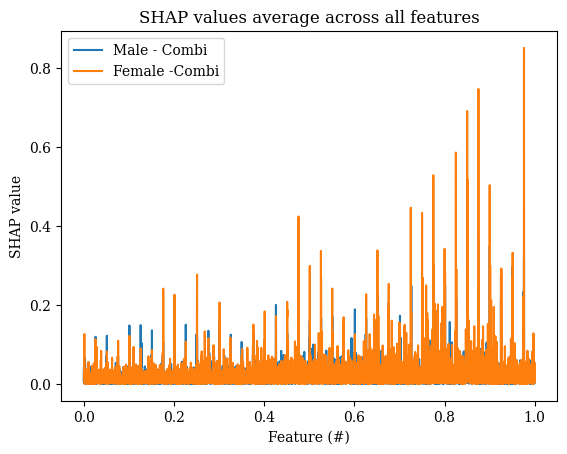

In [21]:

# Assuming shapley_values is already defined and is a 2D array (e.g., list of lists or np.array)
def plot_shapley_values_all_features_all_time(data, labels=None):
    if labels == None:
        labels = [f'{i}' for i in range(len(data))]

    for shapley_value, label in zip(data,labels):
        if type(shapley_value) != np.array:
            try:
                shapley_value = np.array(shapley_value)
            except:
                raise ValueError(f'Data is not a numpy array or a list of lists but of type {type(shapley_value)}'
                                 f'{shapley_value}')
            
            shapley_value = np.sum(np.abs(shapley_value.reshape(100,-1)), axis=0)

            # Calculate the moving average of the last 10 datapoints
            window_size = 400
            moving_average = np.convolve(shapley_value, np.ones(window_size)/window_size, mode='valid')


            # Plot the SHAP values average for all features
            plt.plot(np.linspace(0,1,len(shapley_value)), shapley_value, label=label)
            #plt.plot(range(window_size - 1, shapley_value.shape[0]), moving_average*10, label=f'Moving average (last {window_size})', linestyle='--')

    # Adding title and labels
    plt.title('SHAP values average across all features')
    plt.ylabel('SHAP value')
    plt.xlabel('Feature (#)')

    # Add legend to identify the lines
    plt.legend()

    # Show plot
    plt.show()

labels1 = ['All features', 'No flowers', 'No flowers and bunchload']
data1 = [sv_female_TCNN_all[2], 
         sv_female_TCNN_nf[2], 
         sv_female_TCNN_nfb[2]]

labels2 = ['CNN', 'Combi']
data2 = [sv_female_CNN_nfb[2], 
         sv_female_TCNN_nfb[2]]

labels3 = ['Male - CNN', 'Female - CNN']
data3 = [sv_male_CNN_nfb[2], sv_female_CNN_nfb[2]]

labels4 = ['Male - Combi', 'Female -Combi']
data4 = [sv_male_TCNN_all[2], sv_female_TCNN_all[2]]


plot_shapley_values_all_features_all_time(data4, labels=labels4)

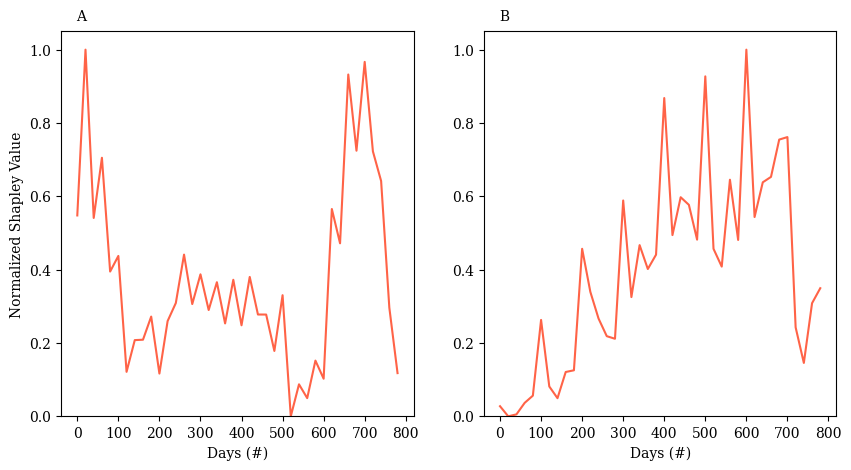

In [32]:
#plt.plot(np.array(sum_time_shaps), label='value')
def plot_all_per_period(data, data2=None, labels=None, plot_events=True):

    spathe_appeared = 42
    leaf_one_point = 36
    sexualization = 6
    if labels == None:
        labels = [f'{i}' for i in range(len(data))]

    for d, label in zip(data,labels):
        d = (d - np.min(d))/np.max(d - np.min(d))
        plt.plot(np.array(d), label=label)

        #plt.hlines(d[-1],39,50, colors='black', linestyles='--')

        # Fill areas
        #plt.fill_between(range(50), sum_time_shaps, alpha=0.3)
        if plot_events:
            plt.fill_between(range(leaf_one_point-2,leaf_one_point+2), d[leaf_one_point-2:leaf_one_point+2], alpha=0.3, color='green')
            plt.fill_between(range(leaf_one_point-1,leaf_one_point+1), d[leaf_one_point-1:leaf_one_point+1], alpha=0.3, color='green', label='Leaf Opening')

            plt.fill_between(range(sexualization-2,sexualization+2), d[sexualization-2:sexualization+2], alpha=0.3, color='blue')
            plt.fill_between(range(sexualization-1,sexualization+1), d[sexualization-1:sexualization+1], alpha=0.3, color='blue', label='Sex determination')

            plt.fill_between(range(spathe_appeared-2,spathe_appeared+2), d[-1], alpha=0.5, color='grey', label='Spathe Appeared')
            plt.fill_between(range(spathe_appeared-1,spathe_appeared+1), d[-1], alpha=0.5, color='grey')
                        


            plt.fill_between(range(38,42), d[-1], alpha=0.3, label= 'Abortion period', color='red')


    #plt.vlines(32, 0, 0.04, colors='black', linestyles='--', label='Leaf Opening')
    #plt.vlines(12, 0, 0.04, colors='black', label='Sex determination')

    plt.xlabel('Days (#)')
    plt.ylabel('SHAP value')
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(range(0, 52, 5),labels=range(0, 1021, 100))
    plt.show()


labels1 = ['All features - Combi', 'No flowers - Combi', 'No flowers and bunchload - Combi']
data1 = [sv_female_TCNN_all[1][2], 
         sv_female_TCNN_nf[1][2], 
         sv_female_TCNN_nfb[1][2]]

labels2 = ['CNN - female', 'Combi - female']
data2 = [sv_female_CNN_nfb[1][2], 
         sv_female_TCNN_nfb[1][2]]

labels2 = ['CNN - male', 'Combi - male']
data2 = [sv_male_CNN_all[1][2], 
         sv_male_TCNN_all[1][2]]


labels3 = ['Male - CNN', 'Female - CNN']
data3 = [sv_male_CNN_nfb[1][2], 
         sv_female_CNN_nfb[1][2]]

labels4 = ['Male - all features', 'Male - no flowers+bunchload']
data4 = [sv_male_CNN_all[1][2],
         sv_male_CNN_nfb[1][2]]

labels5 = ['Male - Combi', 'Female -Combi']
data5 = [sv_male_TCNN_all[1][2], sv_female_TCNN_all[1][2]]

#plot_all_per_period(data3,labels=labels3, plot_events=False)
#plot_all_per_period(data1,labels=labels1, plot_events=False)
#plot_all_per_period(data2,labels=labels2, plot_events=False)
#plot_all_per_period(data4,labels=labels4, plot_events=False)
#plot_all_per_period(data5,labels=labels5, plot_events=False)


from Modules import normalize_array
from matplotlib import rcParams

rcParams['font.family'] = 'serif'  # Change to a serif font\
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.plot(normalize_array(data2[0]), label=labels3[0], c='tomato')
ax1.set_xticks(np.arange(0,41,5))
ax1.set_xticklabels(np.arange(0,801,100))
ax1.set_ylabel('Normalized Shapley Value')
ax1.set_xlabel('Days (#)')
ax1.set_ylim(0)
ax2.plot(normalize_array(data2[1]), label=labels3[1], c='tomato')
ax2.set_xticks(np.arange(0,41,5))
ax2.set_xticklabels(np.arange(0,801,100))
ax2.set_xlabel('Days (#)')
ax2.set_ylim(0)

ax1.text(-0.15,1.08,s='A')
ax2.text(-0.15,1.08,s='B')

plt.savefig('CNNvs.TranformerCNN_male.svg')
plt.show()


In [23]:
#plt.plot(np.array(sum_time_shaps), label='value')
def plot_all_per_period(data, data2=None, plot_events=True):

    spathe_appeared = 42
    leaf_one_point = 36
    sexualization = 6

    plt.plot(np.array(data), color='black')
    plt.hlines(data[-1],39,50, colors='black', linestyles='--')

    if not any(data < 0):
        plt.fill_between(range(49,51), data[-1], alpha=0.5, label='Prediction period', color='orange')
        if data2 is not None:
            plt.plot(np.array(data2), alpha=0.5, color='grey')
        plt.ylim(0)

        # Fill areas
        #plt.fill_between(range(50), sum_time_shaps, alpha=0.3)
    if plot_events:
        plt.fill_between(range(leaf_one_point-2,leaf_one_point+2), data[leaf_one_point-2:leaf_one_point+2], alpha=0.3, color='green')
        plt.fill_between(range(leaf_one_point-1,leaf_one_point+1), data[leaf_one_point-1:leaf_one_point+1], alpha=0.3, color='green', label='Leaf Opening')

        plt.fill_between(range(sexualization-2,sexualization+2), data[sexualization-2:sexualization+2], alpha=0.3, color='blue')
        plt.fill_between(range(sexualization-1,sexualization+1), data[sexualization-1:sexualization+1], alpha=0.3, color='blue', label='Sex determination')

        plt.fill_between(range(spathe_appeared-2,spathe_appeared+2), data[-1], alpha=0.5, color='grey', label='Spathe Appeared')
        plt.fill_between(range(spathe_appeared-1,spathe_appeared+1), data[-1], alpha=0.5, color='grey')
                        


        plt.fill_between(range(38,42), data[-1], alpha=0.3, label= 'Abortion period', color='red')


    if any(data < 0):
        plt.hlines(0, 0, 50, colors='black')   


    #plt.vlines(32, 0, 0.04, colors='black', linestyles='--', label='Leaf Opening')
    #plt.vlines(12, 0, 0.04, colors='black', label='Sex determination')

    plt.xlabel('Days (#)')
    plt.ylabel('SHAP value')
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(range(0, 52, 5),labels=range(0, 1021, 100))
    plt.show()

0.9500000000000001
[8, 15, 9, 12, 0, 7, 13, 18, 17, 2, 11, 4, 3, 5, 1, 10, 6, 14, 16]


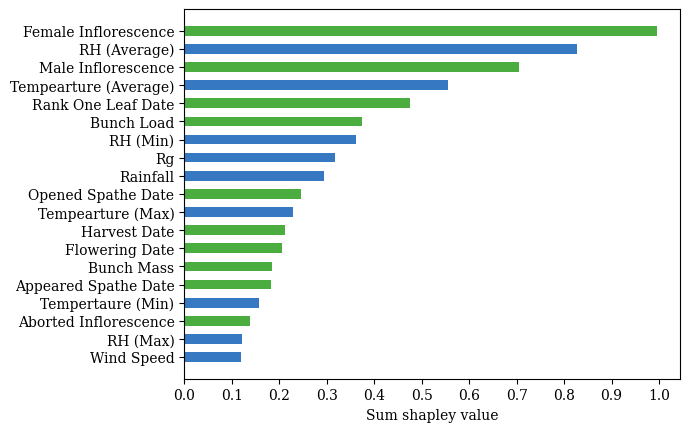

0.9500000000000001
[8, 9, 0, 7, 6, 15, 2, 12, 3, 4, 5, 13, 1, 18, 17, 11, 10, 16, 14]


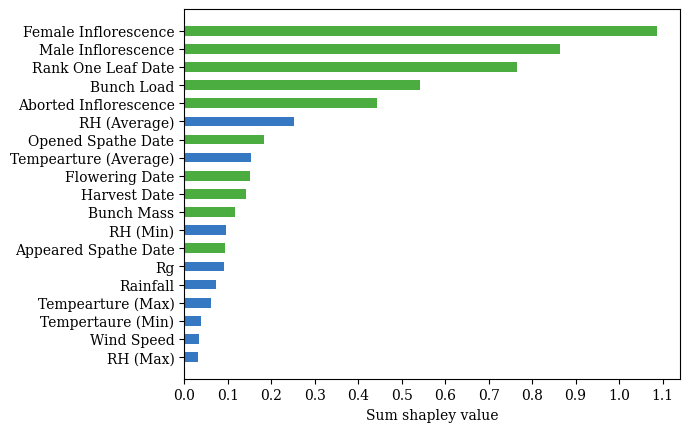

In [29]:
import matplotlib.patches as mpatches
def plot_bar_features(data_, samples, title, scaling = True, ordering=True):
    data = data_.copy()
    feature_labels = get_feature_label(data)
    if scaling:
        # Assuming all_features_shaps and dict_names are already defined
        if len(data) == 19:
            n_pheno_features = 10
        elif len(data) == 16:
            n_pheno_features = 7
        elif len(data) == 17:
            n_pheno_features = 8
        total_features = 40*(n_pheno_features+20*9)
        print((1/n_pheno_features)/(40*20/total_features))
        # Convert the feature SHAP values array to a numpy array if it's not already
        #pheno data
        data[:n_pheno_features] = ((np.array(data)[:n_pheno_features])/samples) * ((1/n_pheno_features)/(40/total_features))
        #weather data
        data[n_pheno_features:] = ((np.array(data)[n_pheno_features:])/samples) * ((1/n_pheno_features)/(20*40/total_features))

    if ordering:
        ordering_ids = np.argsort(data)
        feature_labels = [feature_labels[i] for i in ordering_ids]
        data = data[ordering_ids]
        print(list(ordering_ids)[::-1])

    
    # Create a bar chart with horizontal bars
    plt.barh(np.arange(len(data))*1.5, data, zorder=2, color= ['#4BAC3F' if i < n_pheno_features else '#3778C2' for i in ordering_ids]) 

    # Set y-ticks with feature names
    plt.yticks(np.arange(len(data))*1.5, feature_labels)
    plt.xticks(np.arange(0, np.max(data)*1.1, 0.1))

    #add legend with blue and green label
    labels = ['Phenological features', 'Weather features']
    handels = [mpatches.Patch(color='#4BAC3F'), mpatches.Patch(color='#3778C2')]
    #plt.legend(handels, labels, frameon=False)

    #plt.title(title)
    plt.xlabel('Sum shapley value')


    # Add grid lines for better readability
    #plt.grid( axis='x', which='both',zorder=1)
    plt.savefig(f'/home/u108-n256/PalmProject/NeuralNetwork_Testing/Saved_Objects/Graphs/{title}_all_feature.svg',bbox_inches='tight')
    # Show the plot
    plt.show()

#plot_bar_features(sv_female_TCNN_all[0][1], sv_female_TCNN_all[4], title_sv_female_TCNN_all, scaling=True, ordering=True)
#plot_bar_features(sv_female_TCNN_nf[0][1], sv_female_TCNN_nf[4], title_sv_female_TCNN_nf, scaling=True, ordering=True)
#plot_bar_features(sv_female_TCNN_nfb[0][1], sv_female_TCNN_nfb[4], title_sv_female_TCNN_nfb, scaling=True, ordering=True)

#plot_bar_features(sv_female_CNN_nfb[0][1], sv_female_CNN_nfb[4], title_sv_female_CNN_nfb, scaling=True, ordering=True)
plot_bar_features(sv_male_CNN_all[0][1], sv_male_CNN_all[4], 'CNN', scaling=True, ordering=True)
#plot_bar_features(sv_male_CNN_nfb[0][1], sv_male_CNN_nfb[4], title_sv_male_CNN_nfb, scaling=True, ordering=True)
plot_bar_features(sv_male_TCNN_all[0][1], sv_male_TCNN_all[4], 'CNN_Transformer', scaling=True, ordering=True)

In [25]:
def plot_shaps_overtime(data, n_pheno_features,samples, abs=True):
    for id in range(0,(9+n_pheno_features)-1):

        if abs:
            f = data[id].reshape(samples,-1).__abs__()
        else:
            f = data[id].reshape(samples,-1)
            plt.hlines(0, 0, f.shape[1], color='red')

        f = np.sum(f, axis=0)

        # Plot the sum of SHAP values
        #plt.hlines(0, 0, len(plot_data_sum), color='r')
        leaf_one_point = 36
        sexualization = 6
        if f.__len__() == 40:
            plt.plot(f, color='blue')
            plt.fill_between(range(leaf_one_point-2,leaf_one_point+2), f[leaf_one_point-2:leaf_one_point+2], alpha=0.7, color='green')
            plt.fill_between(range(sexualization-2,sexualization+2), f[sexualization-2:sexualization+2], alpha=0.7, color='blue')
            #plt.fill_between(range(leaf_one_point-1,leaf_one_point+1), f[leaf_one_point-1:leaf_one_point+1], color='red')
            #plt.fill_between(range(sexualization-1,sexualization+1), f[sexualization-1:sexualization+1], alpha=0.3, color='blue')

        if f.__len__() == 800:
            plt.plot(f, color='blue', alpha=0.5)
            plt.fill_between(range((leaf_one_point-2)*20,(leaf_one_point+2)*20), f[(leaf_one_point-2)*20:(leaf_one_point+2)*20], alpha=0.7, color='green')
            plt.fill_between(range((sexualization-2)*20,(sexualization+2)*20), f[(sexualization-2)*20:(sexualization+2)*20], alpha=0.7, color='blue')
            #plt.fill_between(range((leaf_one_point-1)*20,(leaf_one_point+1)*20), f[(leaf_one_point-1)*20:(leaf_one_point+1)*20], color='red')
            #plt.fill_between(range((sexualization-1)*20,(sexualization+1)*20), f[(sexualization-1)*20:(sexualization+1)*20], alpha=0.3, color='blue')
        # Plot the centered moving average of the sum of SHAP values
        #plt.plot(f, label=f'Moving average (window size {window_size})', linestyle='--')
        #labels = list(dict_names.values()) if len(abs_sum_feature_shaps) == 19 else list(dict_names_ex.values())
        plt.title(f'SHAP values sum for {labels[id]}')


        # Add legend to identify the lines
        plt.legend()

        # Show plot
        plt.show()

labels3 = ['Male', 'Female']
data3 = [shap_data_no_flowers_no_bunchload_CNN_m[2], shap_data_no_flowers_no_bunchload_CNN_f[1][2]]
samples3 = [shap_data_all_combi_f[4], shap_data_no_flowers_combi_f[4], shap_data_no_flowers_no_bunchload_combi_f[4]]
n_pheno_features3 = [shap_data_all_combi_f[3], shap_data_no_flowers_combi_f[3], shap_data_no_flowers_no_bunchload_combi_f[3]]

#

NameError: name 'shap_data_no_flowers_no_bunchload_CNN_m' is not defined

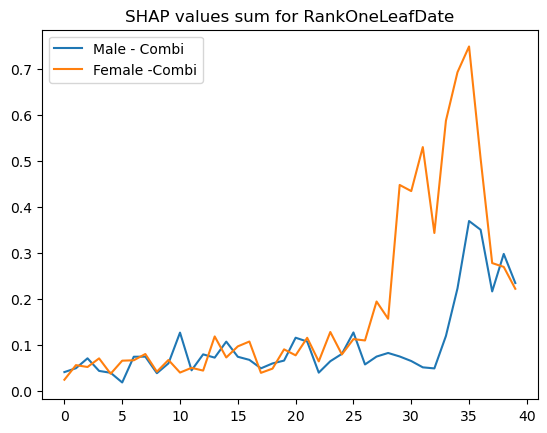

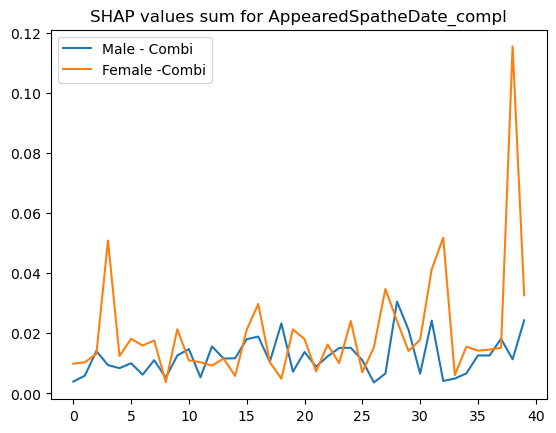

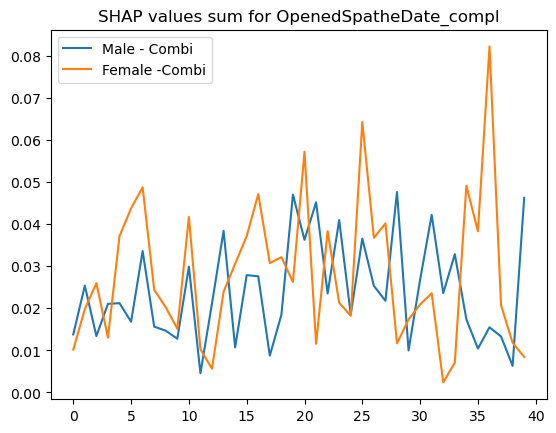

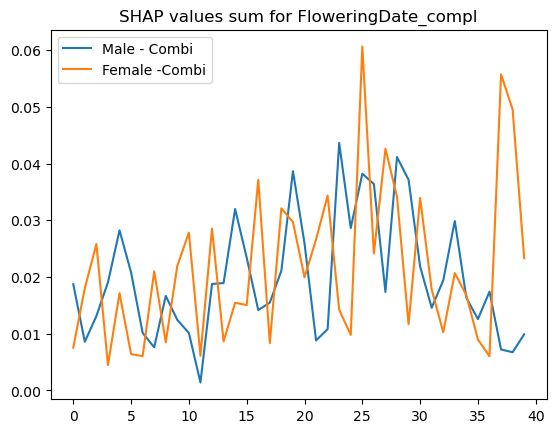

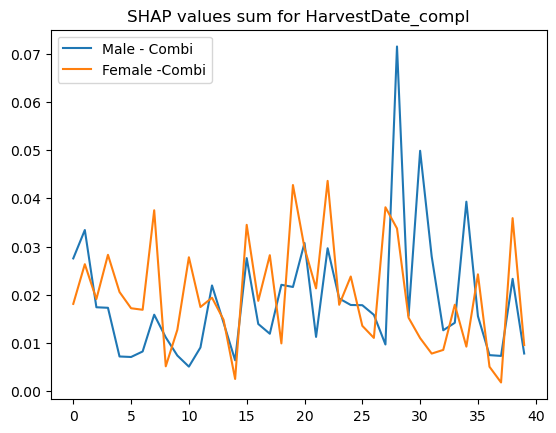

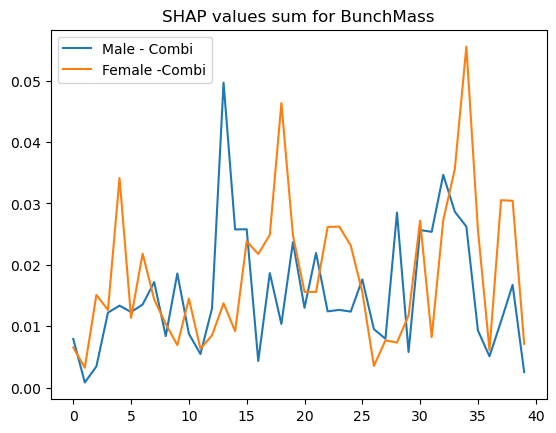

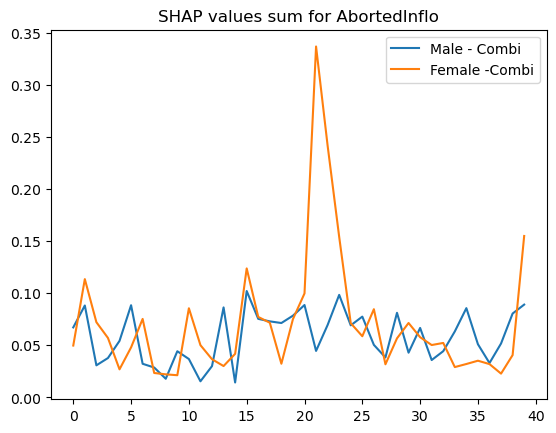

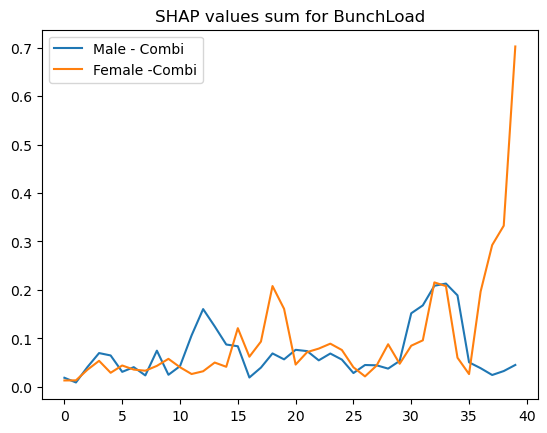

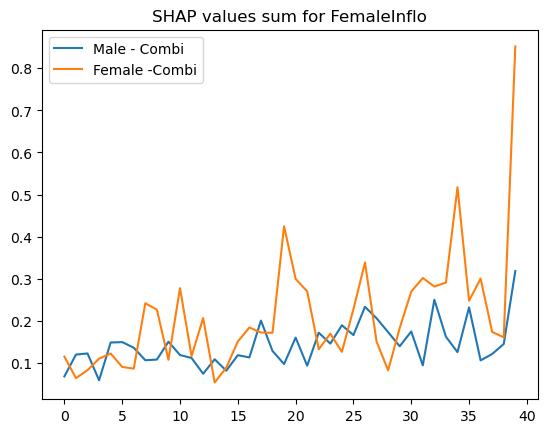

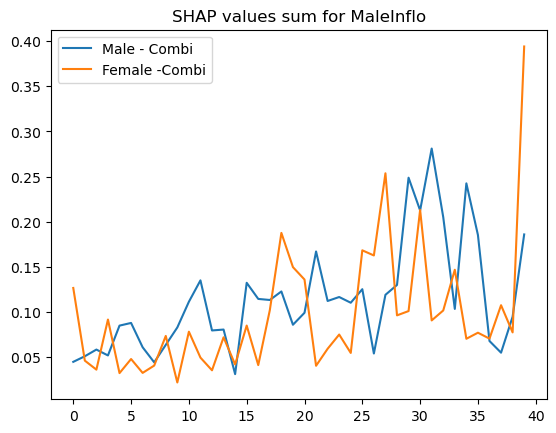

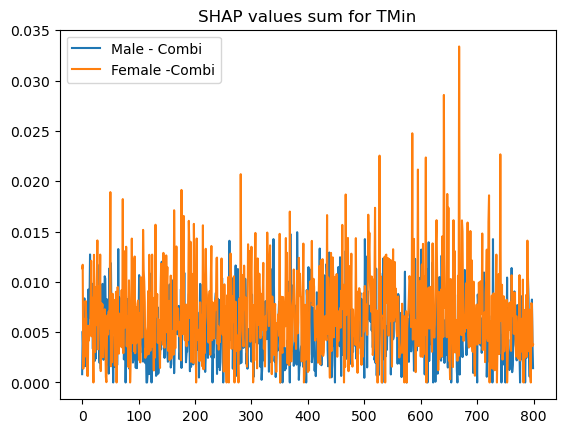

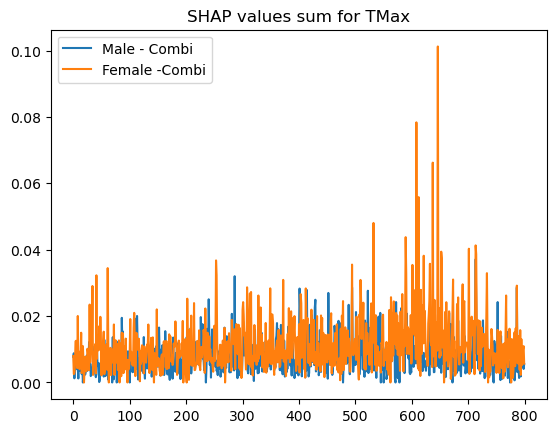

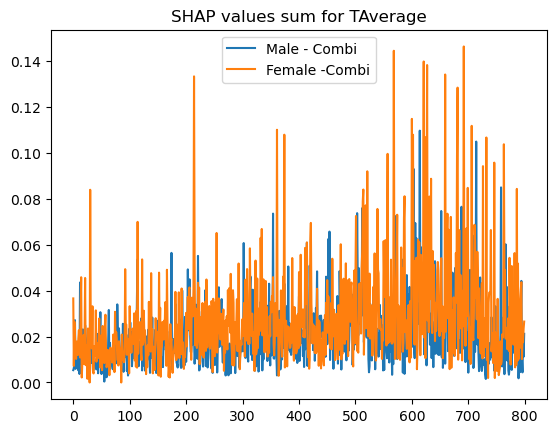

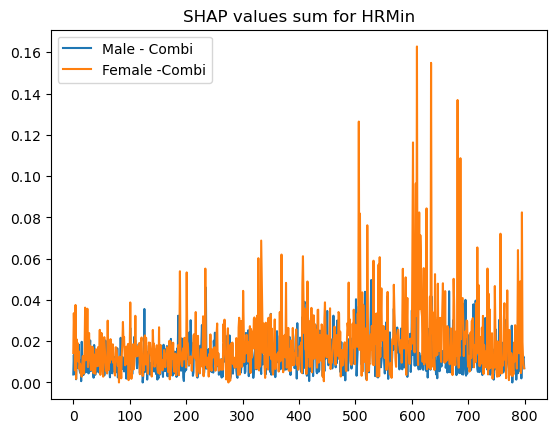

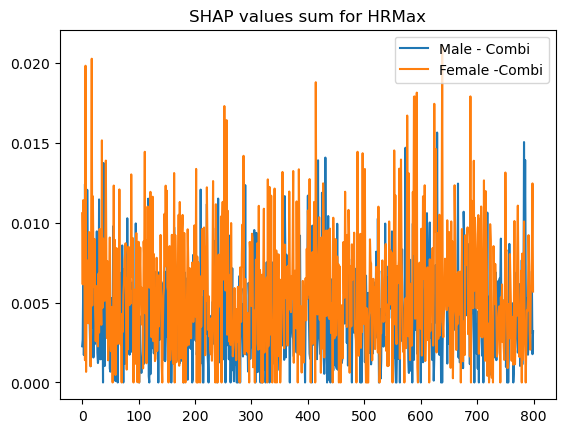

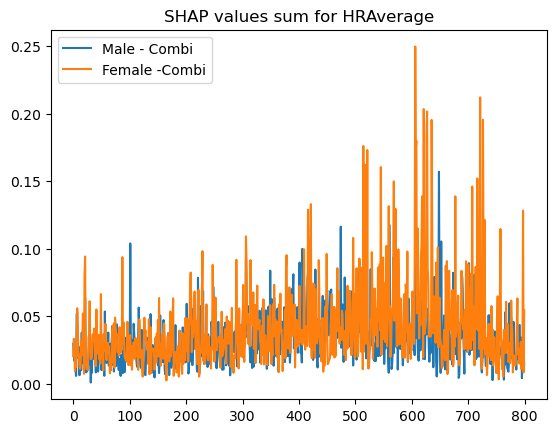

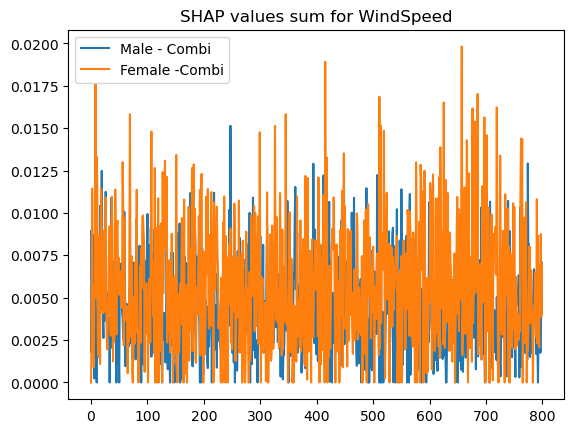

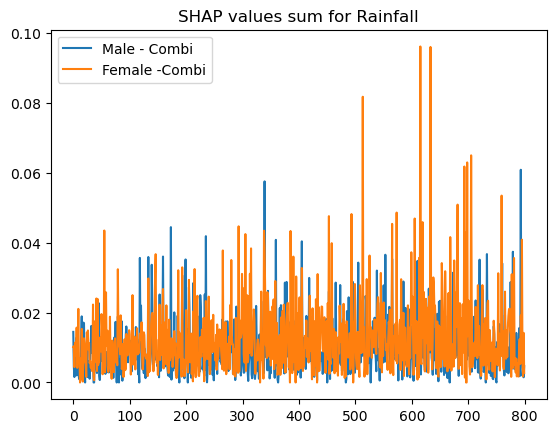

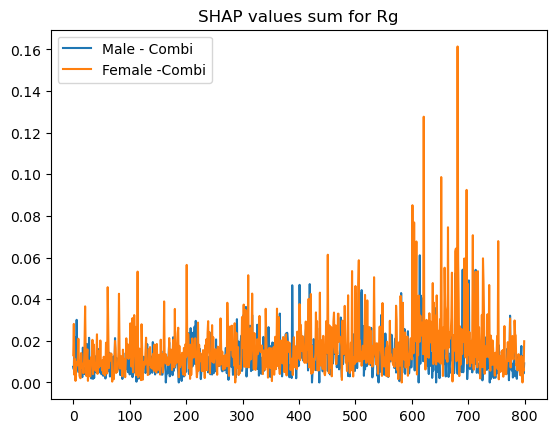

In [ ]:

def plot_feature_correlation(data, labels, samples):

    if labels == None:
        labels = [f'{i}' for i in range(len(data))]
    feature_labels = get_feature_label(data)

    for fi, feature in enumerate(range(len(data[0]))):
        for d, label, sample in zip(data, labels, samples):
            d = d[fi].copy()    
            if type(d) != np.array:
                try:
                    d = np.array(d)
                except:
                    raise ValueError(f'Data is not a numpy array or a list of lists but of type {type(d)}'
                                        f'{d}')
            

            # Calculate the mean and sum of SHAP values across all features
            plot_data_mean = np.mean(np.abs(np.array(d).reshape(sample, -1)), axis=0)
            plot_data_sum = np.sum(np.abs(np.array(d).reshape(sample, -1)), axis=0)
            
            # Determine the window size
            window_size = int(plot_data_mean.shape[0]*0.1)
            half_window = window_size // 2

            # Calculate the moving average with handling of edge effects
            moving_average_sum = np.zeros_like(plot_data_sum)

            for i in range(len(plot_data_sum)):
                start_idx = max(0, i - half_window)
                end_idx = min(len(plot_data_sum), i + half_window + 1)
                moving_average_sum[i] = np.mean(plot_data_sum[start_idx:end_idx])


            plt.plot(plot_data_sum, label=label)

        # Plot the centered moving average of the sum of SHAP values
            moving_average_sum = (moving_average_sum - np.min(moving_average_sum))/np.max(moving_average_sum - np.min(moving_average_sum))
            #plt.plot(moving_average_sum, label=f'{label}', linestyle='--')
        plt.title(f'SHAP values sum for {feature_labels[feature]}')


        # Add legend to identify the lines
        plt.legend()

        # Show plot
        plt.savefig(f'/home/u108-n256/PalmProject/NeuralNetwork_Testing/Saved_Objects/Graphs/Male_Female_SV_combi{fi}.png')
        plt.show()

labels1 = ['All features', 'No flowers', 'No flowers and bunchload']
data1 = [sv_female_TCNN_all[0][0], 
         sv_female_TCNN_nf[0][0], 
         sv_female_TCNN_nfb[0][0]]
samples1 = [sv_female_TCNN_all[4], 
         sv_female_TCNN_nf[4], 
         sv_female_TCNN_nfb[4]]

labels2 = ['CNN - female', 'Combi - female']
data2 = [sv_female_CNN_nfb[0][0], 
         sv_female_TCNN_nfb[0][0]]
samples2 = [sv_female_CNN_nfb[4], 
         sv_female_TCNN_nfb[4]]



labels3 = ['Male - CNN', 'Female - CNN']
data3 = [sv_male_CNN_nfb[0][0], 
         sv_female_CNN_nfb[0][0]]
samples3  = [sv_male_CNN_nfb[4], 
         sv_female_CNN_nfb[4]]

labels4 = ['Male - all features', 'Male - no flowers+bunchload']
data4 = [sv_male_CNN_all[0][0],
         sv_male_CNN_nfb[0][0]]
samples4 = [sv_male_CNN_all[4],
         sv_male_CNN_nfb[4]]

labels5 = ['Male - Combi', 'Female -Combi']
data5 = [sv_male_TCNN_all[0][0], sv_female_TCNN_all[0][0]]
samples5 = [sv_male_TCNN_all[4], sv_female_TCNN_all[4]]

plot_feature_correlation(data5, labels5, samples5)
